In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import mrnn

## Using quadratic tensor forms to solve problems

Such as XOR.

First, what is even the problem?

C = A XOR B has truth table

| A | B | C |
|---|---|---|
| T | T | F |
| T | F | T |
| F | T | T |
| F | F | F |

which, if we assign numeric values, is not linearly separable.

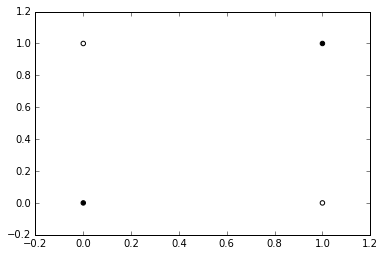

In [5]:
xor_inputs = np.array([[1., 1.],
                       [1., 0.],
                       [0., 1.],
                       [0., 0.]])
xor_targets = np.array([0., 1., 1., 0.])

plt.scatter(xor_inputs[:,0], xor_inputs[:,1], 
            c=[str(val) for val in xor_targets],
            cmap='gray')

With a normal feedforward net, we can't learn this. We can if we incorporate some amount of pairwise information.

In [6]:
def affine(input_var, new_size):
    """get weights and bias, return transformed variable"""
    old_size = input_var.get_shape()[1].value
    weights = tf.get_variable('weights', shape=[old_size, new_size])
    bias = tf.get_variable('bias', shape=[new_size])
    return tf.nn.bias_add(tf.matmul(input_var, weights), bias)

def quadratic(input_var, output_size, rank):
    """Get tensor and biases etc."""
    input_size = input_var.get_shape()[1].value
    tensor = mrnn.get_cp_tensor([input_size, output_size, input_size],
                                rank)
    weights = tf.get_variable('weights', shape=[input_size, output_size])
    bias = tf.get_variable('bias', shape=[new_size])
    
    result = mrnn.bilinear_product_cp(input_var, tensor, input_var)
    
    
    return result + tf.matmul(input_var, weights) + bias 